## Data Update for 2024-06-10 export - Infilling one day

Notes for this script:

The only thing that needs to be adjusted each time this code is ran is the name of the data being read in and figure names. 
This can easily change these using command + F and searching the date associated with the file such as 06-10 or Jun10.

When infilling one day of data, I choose to find any rows of data that are within three consecutive days (the day before, the day missing data, and the day after). Once I have this, I infill any instances where the distance travelled in the missing day is less than 350 km, or the change in either latitude or longitude is less than 2 degrees. 
These parameters were chosen in a different script where I analyzed the distribution of the spread of distances traveled/changes in latitude and longitude across all instances the rows found within three consecutive days. These parameters change depending on how many days missing data we want to infill.

Infilling is done in three steps:
1. Find rows missing one day of both latitude and longitude with the surrounding days having values. Find the distance that would be travelled over the missing day using the values from the day before and after. Infill by interpolating values for the gap (similar to finding the mid point) again using the day before and the day after.
2. Find rows in the latitude column just missing one day with the surrounding days having latitude values. Find the difference in latitude between the day before and day after. Infill using interpolation.
3. Find rows in the longitude column just missing one day with the surrounding days having longitude values. Find the difference in longitude between the day before and day after. Infill using interpolation.  

In [1]:
# Import
# Not all of these are used in this script, but they're good to have just in case 

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime, os
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import seaborn as sns
from tabulate import tabulate
import sys
from matplotlib.colors import Normalize
from geopy.distance import geodesic
from scipy import stats

pd.options.display.max_columns = 50

print("Last updated on {}".format(datetime.datetime.now().ctime()))

Last updated on Wed Jun 12 10:27:25 2024


In [2]:
# Import Cleaned Tier 1 Data
df = pd.read_pickle("Tier1_logentries-export-2024-06-10.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96383 entries, 0 to 98177
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DateTime                    96378 non-null  object        
 1   ID                          96380 non-null  float64       
 2   LogBook ID                  96379 non-null  object        
 3   Page                        59413 non-null  float64       
 4   Latitude                    72421 non-null  float64       
 5   Longitude                   62459 non-null  float64       
 6   Depth                       2134 non-null   float64       
 7   Depth Unit                  22937 non-null  object        
 8   Bottom                      63 non-null     object        
 9   Landmark                    15197 non-null  object        
 10  Ship Heading/Course         53219 non-null  object        
 11  Wind Direction              67518 non-null  object        


In [3]:
# Setting up a folder system 
# Create folders called "Figures" and "Text/CSV Files" manually (right click + new folder on left side)

# Get current directory
current_directory = os.getcwd()

# Specify the path to the folder
Figures = os.path.join(current_directory, 'Figures')
Files = os.path.join(current_directory, 'Text Files')
CSV = os.path.join(current_directory, 'CSV Files')

In [4]:
# This step is done in the cleaning Tier 1 script, so may not be needed again, but just in case

# Sorting data by logbook ID, date, and landmark
# Create a unique separator that does not appear in data
separator = '###'

# Replace consecutive spaces with the separator in the 'Landmark' column
df['Landmark'] = df['Landmark'].str.replace(r'\s+', separator, regex=True)

# Sort the DataFrame
df = df.sort_values(by=['LogBook ID', 'DateTime', 'Landmark'])

# Replace the separator with a single space
df['Landmark'] = df['Landmark'].str.replace(separator, ' ')

In [5]:
#Creating a dataframe of usable data
df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna())
df_u = df[df['usable']==True]
df_u

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,usable,usable_latlon,usable_lat
96400,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.850000,-58.466667,NaN,NaN,NaN,NaN,SE,225.0,moderate gales,7.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-06 12:00:00,nan,SW,False,True,True,True
96398,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.250000,-55.066667,NaN,NaN,NaN,NaN,NaN,225.0,fresh breezes,5.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-07 12:00:00,nan,SW,False,True,True,True
96396,1853-07-09 12:00:00,2446.0,A. Houghton (bark) 1853-1857,NaN,33.750000,-52.466667,NaN,NaN,NaN,NaN,SSE,225.0,light,2.0,NaN,NaN,fine,NaN,NaN,False,1853-07-09 12:00:00,nan,SW,False,True,True,True
96395,1853-07-10 12:00:00,2447.0,A. Houghton (bark) 1853-1857,NaN,33.333333,-53.716667,NaN,NaN,NaN,NaN,S,NaN,light airs,1.0,calms,NaN,NaN,NaN,NaN,False,1853-07-10 12:00:00,nan,NaN,False,True,True,True
96393,1853-07-12 12:00:00,2449.0,A. Houghton (bark) 1853-1857,NaN,33.816667,-53.066667,NaN,NaN,NaN,NaN,NaN,135.0,moderate winds,4.0,NaN,NaN,clear,NaN,NaN,False,1853-07-12 12:00:00,nan,SE,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1837-01-06 12:00:00,101316.0,Young Phenix (ship) 1836-1840,NaN,18.266667,-23.616667,NaN,fathoms,NaN,NaN,S,22.5,small breezes,2.0,NaN,NaN,fine,NaN,NaN,False,1837-01-06 12:00:00,nan,NNE,False,True,True,True
56,1837-01-07 12:00:00,101317.0,Young Phenix (ship) 1836-1840,NaN,16.466667,-23.050000,NaN,fathoms,NaN,NaN,S by E,45.0,strong trades,6.0,NaN,NaN,NaN,NaN,NaN,False,1837-01-07 12:00:00,nan,NE,False,True,True,True
55,1837-01-08 12:00:00,101318.0,Young Phenix (ship) 1836-1840,NaN,14.433333,-23.900000,NaN,fathoms,NaN,NaN,SW by S,NaN,strong trade,6.0,NaN,clear,NaN,NaN,NaN,False,1837-01-08 12:00:00,nan,NaN,False,True,True,True
54,1837-01-09 12:00:00,101319.0,Young Phenix (ship) 1836-1840,NaN,11.650000,-22.733333,NaN,fathoms,NaN,NaN,S,NaN,strong trade,6.0,NaN,passing clouds,NaN,NaN,NaN,False,1837-01-09 12:00:00,nan,NaN,False,True,True,True


# Taking the clean data and infilling where one day of data is missing

### Infilling one day missing both latitude and longitude

In [6]:
# Finding distance traveled in instances of three consecutive days
# We need three consecutive days to find the missing day, the day before and the day after

# Sort the DataFrame by 'LogBook ID' and 'DateTime'
df_sorted = df.sort_values(by=['LogBook ID', 'DateTime'])

# Initialize the new column
df_sorted['One Day Dist'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_selected, date_below):
    if all(pd.notna(date) for date in [date_above, date_selected, date_below]):
        # Check if dates are consecutive
        return (date_selected - date_above).days == 1 and (date_below - date_selected).days == 1
    return False

# Iterate through the sorted DataFrame to check for the conditions
for i in range(1, len(df_sorted) - 1):  # Start from the second row and end before the last row
    # If you get an error x and y are different dimensions change len(df_sorted) - 1 to be -2, ect. 
    if np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')]):
        # Check if both Longitude and Latitude are NaN in the current row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])):
                # Check if Latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_selected = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()

                if are_consecutive_dates(date_above, date_selected, date_below):
                    # Check if dates are consecutive
                    
                    # If all that is true, calculate distance for each consecutive pair of points
                    latitude1, longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                    latitude2, longitude2 = df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')]
                    distance = geodesic((latitude1, longitude1), (latitude2, longitude2)).kilometers

                    # Update the 'One Day Dist' column
                    df_sorted.at[df_sorted.index[i], 'One Day Dist'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'One Day Dist']])

# Saving data to a CSV file
df['One Day Dist'] = df_sorted['One Day Dist'] # Saves this to original dataframe
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  One Day Dist
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [7]:
# Interpolate missing lat and lon for distances less than 350 km

# Add a new column to the dataframe to keep track of infilling
df['Infilled'] = False

# Iterate over the DataFrame index to find rows with 'One Day Dist' less than 350.00
for i in range(len(df_sorted)):
    if i == 0 or i == len(df_sorted) - 1:
        continue  # Skip first and last rows

    if df_sorted.at[df_sorted.index[i], 'One Day Dist'] < 350.00:
        # Select rows between i-1 and i+2
        selected_rows = df_sorted.iloc[i-1:i+2][['Latitude', 'Longitude']]

        # Interpolate between where the condition is met
        
        # Handle instances where longitude crosses antimeridian at 180 
        # First value is negative (west) and last value is positive (east): ex. -179 to 179
        if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
        # First value is positive (east) and second value is negative (west): ex. 179 to -179
        elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
        # Interpolate all other data gaps
        else:
            interpolated_values = selected_rows.interpolate(method='linear')

        # Assign interpolated values to Latitude and Longitude columns for i
        df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
        df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']

        # Mark the infilled column as true
        df.at[df_sorted.index[i], 'Infilled'] = True

        # Mark the new infilled column as true, this is for plotting purposes and will be deleted later 
        df.at[df_sorted.index[i], 'Day 1 Infilled'] = True

# Print the DataFrame to verify the new columns
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'One Day Dist']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index=False)


/tmp/ipykernel_604313/1230704285.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[df_sorted.index[i], 'Day 1 Infilled'] = True


                  DateTime   Latitude  Longitude  One Day Dist
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [8]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 1769


### Infilling one day missing just latitude

In [9]:
# Finding one day of latitude missing in instances of three consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the latitude column

# Initialize the new column
df_sorted['One Day Lat'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_selected, date_below):
    if all(pd.notna(date) for date in [date_above, date_selected, date_below]):
        # Check if dates are consecutive
        return (date_selected - date_above).days == 1 and (date_below - date_selected).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(1, len(df_sorted) - 1):  # Start from the second row and end before the last row
    if np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')]):
        # Check if both Longitude and Latitude are NaN in the current row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
            date_selected = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
            date_below = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()

            if are_consecutive_dates(date_above, date_selected, date_below):
                # Check if dates are consecutive
                
                # Calculate change in lat for each consecutive pair of points
                latitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]
                latitude2 = df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')]
                distance = latitude1-latitude2
                
                # Update the 'One Day Dist' column
                df_sorted.at[df_sorted.index[i], 'One Day Lat'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'One Day Lat']]) 
df['One Day Lat'] = df_sorted['One Day Lat']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  One Day Lat
12264                  4.5        NaN        NaN          NaN
12266                   10        NaN        NaN          NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667          NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667          NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000          NaN
...                    ...        ...        ...          ...
53     1837-01-10 12:00:00   8.733333 -21.933333          NaN
570                    NaN        NaN        NaN          NaN
5817                   NaN        NaN        NaN          NaN
12270                  NaN        NaN        NaN          NaN
21835                  NaN        NaN        NaN          NaN

[96383 rows x 4 columns]


In [10]:
# Filling in days where latitude difference is less than 2 degrees

# Iterate over the DataFrame index to find rows with 'One Day Lat' less than 2
for i in range(len(df_sorted)):
    if i == 0 or i == len(df_sorted) - 1:
        continue  # Skip first and last rows

    if -2.01 < df_sorted.at[df_sorted.index[i], 'One Day Lat'] < 2.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Latitude']):
            continue
        else:
            # Select rows between i-1 and i+1
            selected_rows = df_sorted.iloc[i-1:i+2][['Latitude', 'Longitude']]
        
            # Interpolate between where the condition is met
            interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to Latitude column for i
            df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']

            # Mark the infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True

            # Mark the new infilled column as true
            df.at[df_sorted.index[i], 'Day 1 Infilled'] = True

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'One Day Lat']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  One Day Lat
12264                  4.5        NaN        NaN          NaN
12266                   10        NaN        NaN          NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667          NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667          NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000          NaN
...                    ...        ...        ...          ...
53     1837-01-10 12:00:00   8.733333 -21.933333          NaN
570                    NaN        NaN        NaN          NaN
5817                   NaN        NaN        NaN          NaN
12270                  NaN        NaN        NaN          NaN
21835                  NaN        NaN        NaN          NaN

[96383 rows x 4 columns]


In [11]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 3377


### Infilling one day with just longitude missing

In [12]:
# Finding one day of longitude missing in instances of three consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above but only for longitude

# Initialize the new column
df_sorted['One Day Lon'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_selected, date_below):
    if all(pd.notna(date) for date in [date_above, date_selected, date_below]):
        # Check if dates are consecutive
        return (date_selected - date_above).days == 1 and (date_below - date_selected).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(1, len(df_sorted) - 1):  # Start from the second row and end before the last row
    if np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')]):
        # Check if both Longitude and Latitude are NaN in the current row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
            date_selected = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
            date_below = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()

            if are_consecutive_dates(date_above, date_selected, date_below):
                # Check if dates are consecutive
                # Calculate change in lon for each consecutive pair of points
                longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                longitude2 = df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')]

                # Calculate the raw difference
                raw_difference = longitude1 - longitude2

                # Define the threshold for crossing over 175°E or -175°
                threshold = 175

                # Adjust the raw difference if it crosses over the threshold
                if (longitude1 > threshold and longitude2 < -threshold) or (longitude1 < -threshold and longitude2 > threshold):
                    if raw_difference > 0:
                        distance = raw_difference - 360
                    else:
                        distance = raw_difference + 360
                else:
                    distance = raw_difference

                # Update the 'One Day Lon' column
                df_sorted.at[df_sorted.index[i], 'One Day Lon'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'One Day Lon']])
df['One Day Lon'] = df_sorted['One Day Lon']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  One Day Lon
12264                  4.5        NaN        NaN          NaN
12266                   10        NaN        NaN          NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667          NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667          NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000          NaN
...                    ...        ...        ...          ...
53     1837-01-10 12:00:00   8.733333 -21.933333          NaN
570                    NaN        NaN        NaN          NaN
5817                   NaN        NaN        NaN          NaN
12270                  NaN        NaN        NaN          NaN
21835                  NaN        NaN        NaN          NaN

[96383 rows x 4 columns]


In [13]:
# Filling in days where longitude difference is less than 2 degrees

# Iterate over the DataFrame index to find rows with 'One Day Lon' less than 2
for i in range(len(df_sorted)):
    if i == 0 or i == len(df_sorted) - 1:
        continue  # Skip first and last rows

    if -2.01 < df_sorted.at[df_sorted.index[i], 'One Day Lon'] < 2.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Longitude']):
            continue
        else:
            # Select rows between i-1 and i+1
            selected_rows = df_sorted.iloc[i-1:i+2][['Latitude', 'Longitude']]

            # Interpolate between where the condition is met
        
            # Handle longitude wrap-around for interpolation
            # First value is negative (west) and last value is positive (east): ex. -179 to 179
            if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
            # First value is positive (east) and second value is negative (west): ex. 179 to -179
            elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
            # Interpolate all other data gaps
            else:
                interpolated_values = selected_rows.interpolate(method='linear')

            # Store the interpolated longitude values in the new column
            df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']

            # Mark the 'Infilled' column as true
            df.at[df_sorted.index[i], 'Infilled'] = True

            # Mark the new infilled column as true
            df.at[df_sorted.index[i], 'Day 1 Infilled'] = True

# Print the DataFrame to verify the changes
print(df_sorted[['DateTime', 'Latitude', 'Longitude']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude
12264                  4.5        NaN        NaN
12266                   10        NaN        NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667
96398  1853-07-07 12:00:00  37.250000 -55.066667
96397  1853-07-08 12:00:00  35.000000 -53.400000
...                    ...        ...        ...
53     1837-01-10 12:00:00   8.733333 -21.933333
570                    NaN        NaN        NaN
5817                   NaN        NaN        NaN
12270                  NaN        NaN        NaN
21835                  NaN        NaN        NaN

[96383 rows x 3 columns]


In [14]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 5123


In [15]:
# Moving the infilled column to be next to the longitude column

# Extract the 'Infilled' column
infilled_column = df['Infilled']

# Drop the 'Infilled' column from its current position
df.drop(columns=['Infilled'], inplace=True)

# Find the index of the 'Longitude' column
longitude_index = df.columns.get_loc('Longitude')

# Insert the 'Infilled' column next to the 'Longitude' column
df.insert(longitude_index + 1, 'Infilled', infilled_column)

# Print the DataFrame to verify the column positions
#print(df.head())


In [16]:
#Creating a dataframe of usable data
df['Tier2_usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna())
df_u2 = df[df['Tier2_usable']==True]
df_u2

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,usable,usable_latlon,usable_lat,One Day Dist,Day 1 Infilled,One Day Lat,One Day Lon,Tier2_usable
96400,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.850000,-58.466667,False,NaN,NaN,NaN,NaN,SE,225.0,moderate gales,7.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-06 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,NaN,True
96398,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.250000,-55.066667,False,NaN,NaN,NaN,NaN,NaN,225.0,fresh breezes,5.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-07 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,NaN,True
96396,1853-07-09 12:00:00,2446.0,A. Houghton (bark) 1853-1857,NaN,33.750000,-52.466667,False,NaN,NaN,NaN,NaN,SSE,225.0,light,2.0,NaN,NaN,fine,NaN,NaN,False,1853-07-09 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,NaN,True
96395,1853-07-10 12:00:00,2447.0,A. Houghton (bark) 1853-1857,NaN,33.333333,-53.716667,False,NaN,NaN,NaN,NaN,S,NaN,light airs,1.0,calms,NaN,NaN,NaN,NaN,False,1853-07-10 12:00:00,nan,NaN,False,True,True,True,NaN,NaN,NaN,NaN,True
96393,1853-07-12 12:00:00,2449.0,A. Houghton (bark) 1853-1857,NaN,33.816667,-53.066667,False,NaN,NaN,NaN,NaN,NaN,135.0,moderate winds,4.0,NaN,NaN,clear,NaN,NaN,False,1853-07-12 12:00:00,nan,SE,False,True,True,True,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1837-01-06 12:00:00,101316.0,Young Phenix (ship) 1836-1840,NaN,18.266667,-23.616667,False,NaN,fathoms,NaN,NaN,S,22.5,small breezes,2.0,NaN,NaN,fine,NaN,NaN,False,1837-01-06 12:00:00,nan,NNE,False,True,True,True,NaN,NaN,NaN,NaN,True
56,1837-01-07 12:00:00,101317.0,Young Phenix (ship) 1836-1840,NaN,16.466667,-23.050000,False,NaN,fathoms,NaN,NaN,S by E,45.0,strong trades,6.0,NaN,NaN,NaN,NaN,NaN,False,1837-01-07 12:00:00,nan,NE,False,True,True,True,NaN,NaN,NaN,NaN,True
55,1837-01-08 12:00:00,101318.0,Young Phenix (ship) 1836-1840,NaN,14.433333,-23.900000,False,NaN,fathoms,NaN,NaN,SW by S,NaN,strong trade,6.0,NaN,clear,NaN,NaN,NaN,False,1837-01-08 12:00:00,nan,NaN,False,True,True,True,NaN,NaN,NaN,NaN,True
54,1837-01-09 12:00:00,101319.0,Young Phenix (ship) 1836-1840,NaN,11.650000,-22.733333,False,NaN,fathoms,NaN,NaN,S,NaN,strong trade,6.0,NaN,passing clouds,NaN,NaN,NaN,False,1837-01-09 12:00:00,nan,NaN,False,True,True,True,NaN,NaN,NaN,NaN,True


# Creating Figures

Number of entries covered by the mapping so far:  55358


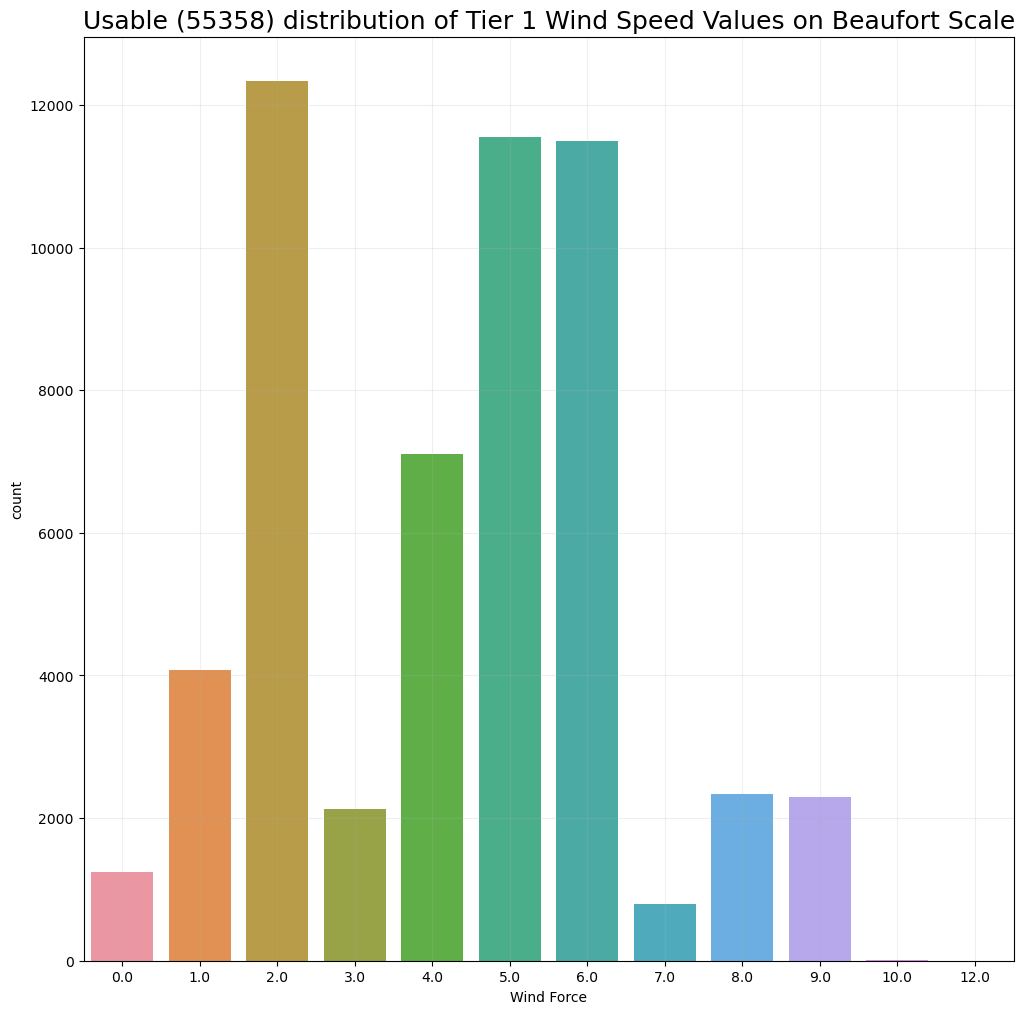

In [17]:
# Beaufort wind scale for Tier 1 usable data (no infilling)
num_entries = np.size(df_u['Wind Force'])
print('Number of entries covered by the mapping so far: ', num_entries)

# Plotting the data
f, ax = plt.subplots(figsize=(12, 12))
sns.countplot(x=df_u["Wind Force"]) # plot the Tier 1 data on a count plot
ax.grid(alpha=0.2) # adds a grid
plt.title(f'Usable ({num_entries}) distribution of Tier 1 Wind Speed Values on Beaufort Scale', fontsize=18)
plt.savefig(os.path.join(Figures, 'Tier1_Distribution_Beaufort Scale_Jun10.png'), dpi=300, bbox_inches='tight')


Number of entries covered by the mapping so far:  58463


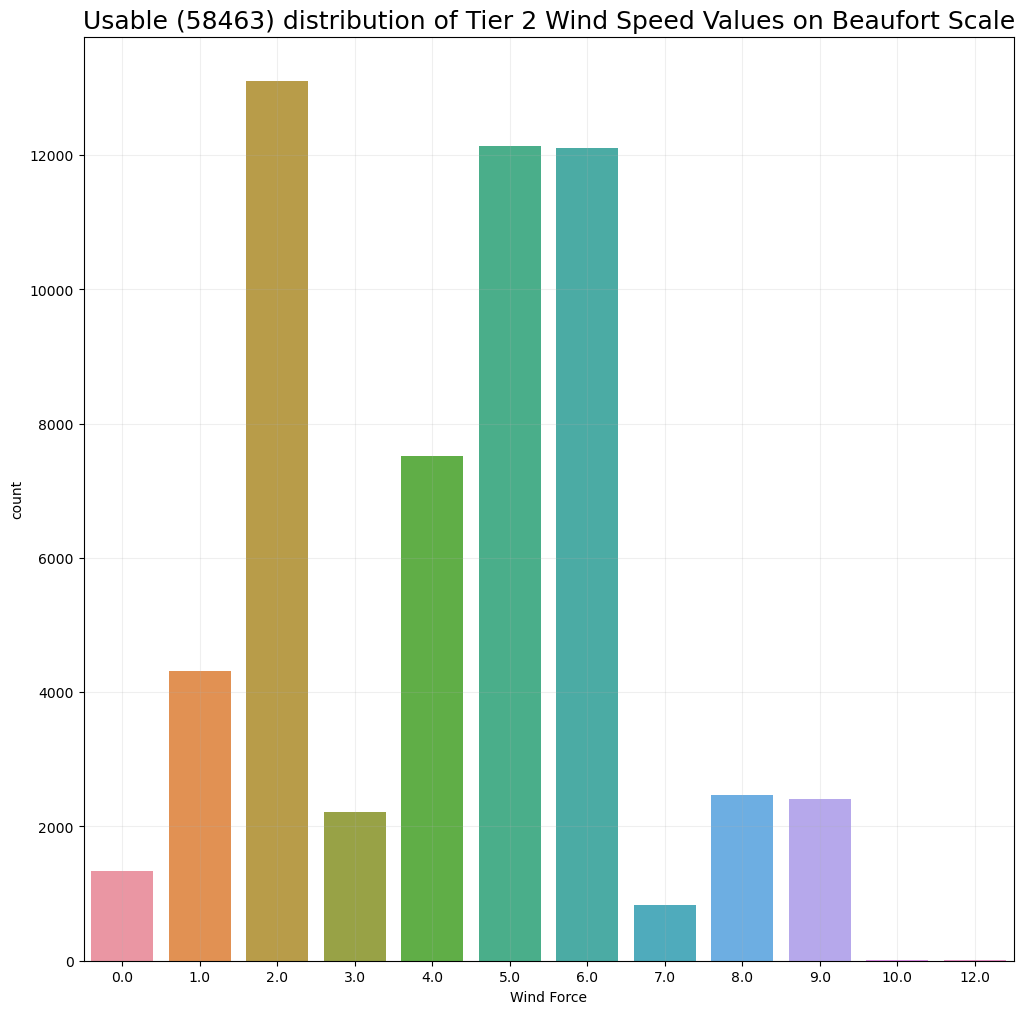

In [18]:
# Beaufort wind scale for Tier 2 usable data
num_entries = np.size(df_u2['Wind Force'])
print('Number of entries covered by the mapping so far: ', num_entries)

# Plotting the data
f, ax = plt.subplots(figsize = (12,12))
sns.countplot(x=df_u2["Wind Force"]) # Plotting Tier 2 wind force data
ax.grid(alpha=0.2) # add a light grid to background
plt.title(f'Usable ({num_entries}) distribution of Tier 2 Wind Speed Values on Beaufort Scale',fontsize=18)
plt.savefig(os.path.join(Figures, 'Tier2_Distribution_Beaufort Scale_Jun10.png'),dpi=300,bbox_inches='tight')


In [19]:
# Testing the statistical significance of this wind distribution compared to the overall 

# Mann Whitney U Test
# Non-parametric test - test that distribution x is the same as y, test of difference in location btwn dist

#Set parameters
x = df_u["Wind Force"] #overall usable wind distribution
y = df_u2["Wind Force"] #new wind distribution from infilling one day (lat&lon)

# Run Mann Whitney U Test
result_mannwhitneyu = stats.mannwhitneyu(x,y)

# Print results
print('Mann Whitney U Test:', result_mannwhitneyu)

# Kruskal_Wallis Test
# Non-parametric test - data is not assumed to be from a particular distribution

# Run Kruskal Wallis Test
result_kruskal = stats.kruskal(x,y)

# Print results
print('Kruskal-Wallis Test:', result_kruskal)

Mann Whitney U Test: MannwhitneyuResult(statistic=1621449520.5, pvalue=0.550811787020653)
Kruskal-Wallis Test: KruskalResult(statistic=0.3558649998724105, pvalue=0.5508117257628227)


1826 :  (82, 33)
1827 :  (284, 33)
1828 :  (347, 33)
1829 :  (553, 33)
1830 :  (875, 33)
1831 :  (1014, 33)
1832 :  (942, 33)
1833 :  (857, 33)
1834 :  (861, 33)
1835 :  (1666, 33)
1836 :  (2018, 33)
1837 :  (2518, 33)
1838 :  (1805, 33)
1839 :  (1382, 33)
1840 :  (721, 33)
1841 :  (905, 33)
1842 :  (924, 33)
1843 :  (1374, 33)
1844 :  (1807, 33)
1845 :  (1910, 33)
1846 :  (3326, 33)
1847 :  (3975, 33)
1848 :  (2592, 33)
1849 :  (2076, 33)
1850 :  (2202, 33)
1851 :  (2620, 33)
1852 :  (2413, 33)
1853 :  (1495, 33)
1854 :  (729, 33)
1855 :  (376, 33)
1856 :  (171, 33)
1857 :  (340, 33)
1858 :  (286, 33)
1859 :  (237, 33)
1860 :  (135, 33)
1861 :  (172, 33)
1862 :  (176, 33)
1863 :  (165, 33)
1864 :  (455, 33)
1865 :  (853, 33)
1866 :  (930, 33)
1867 :  (528, 33)
1868 :  (415, 33)
1869 :  (229, 33)
1870 :  (28, 33)
1871 :  (213, 33)
1872 :  (126, 33)
1873 :  (121, 33)
1874 :  (247, 33)
1875 :  (150, 33)
1876 :  (102, 33)
1877 :  (418, 33)
1878 :  (1621, 33)
1879 :  (1892, 33)
1880 :  (11

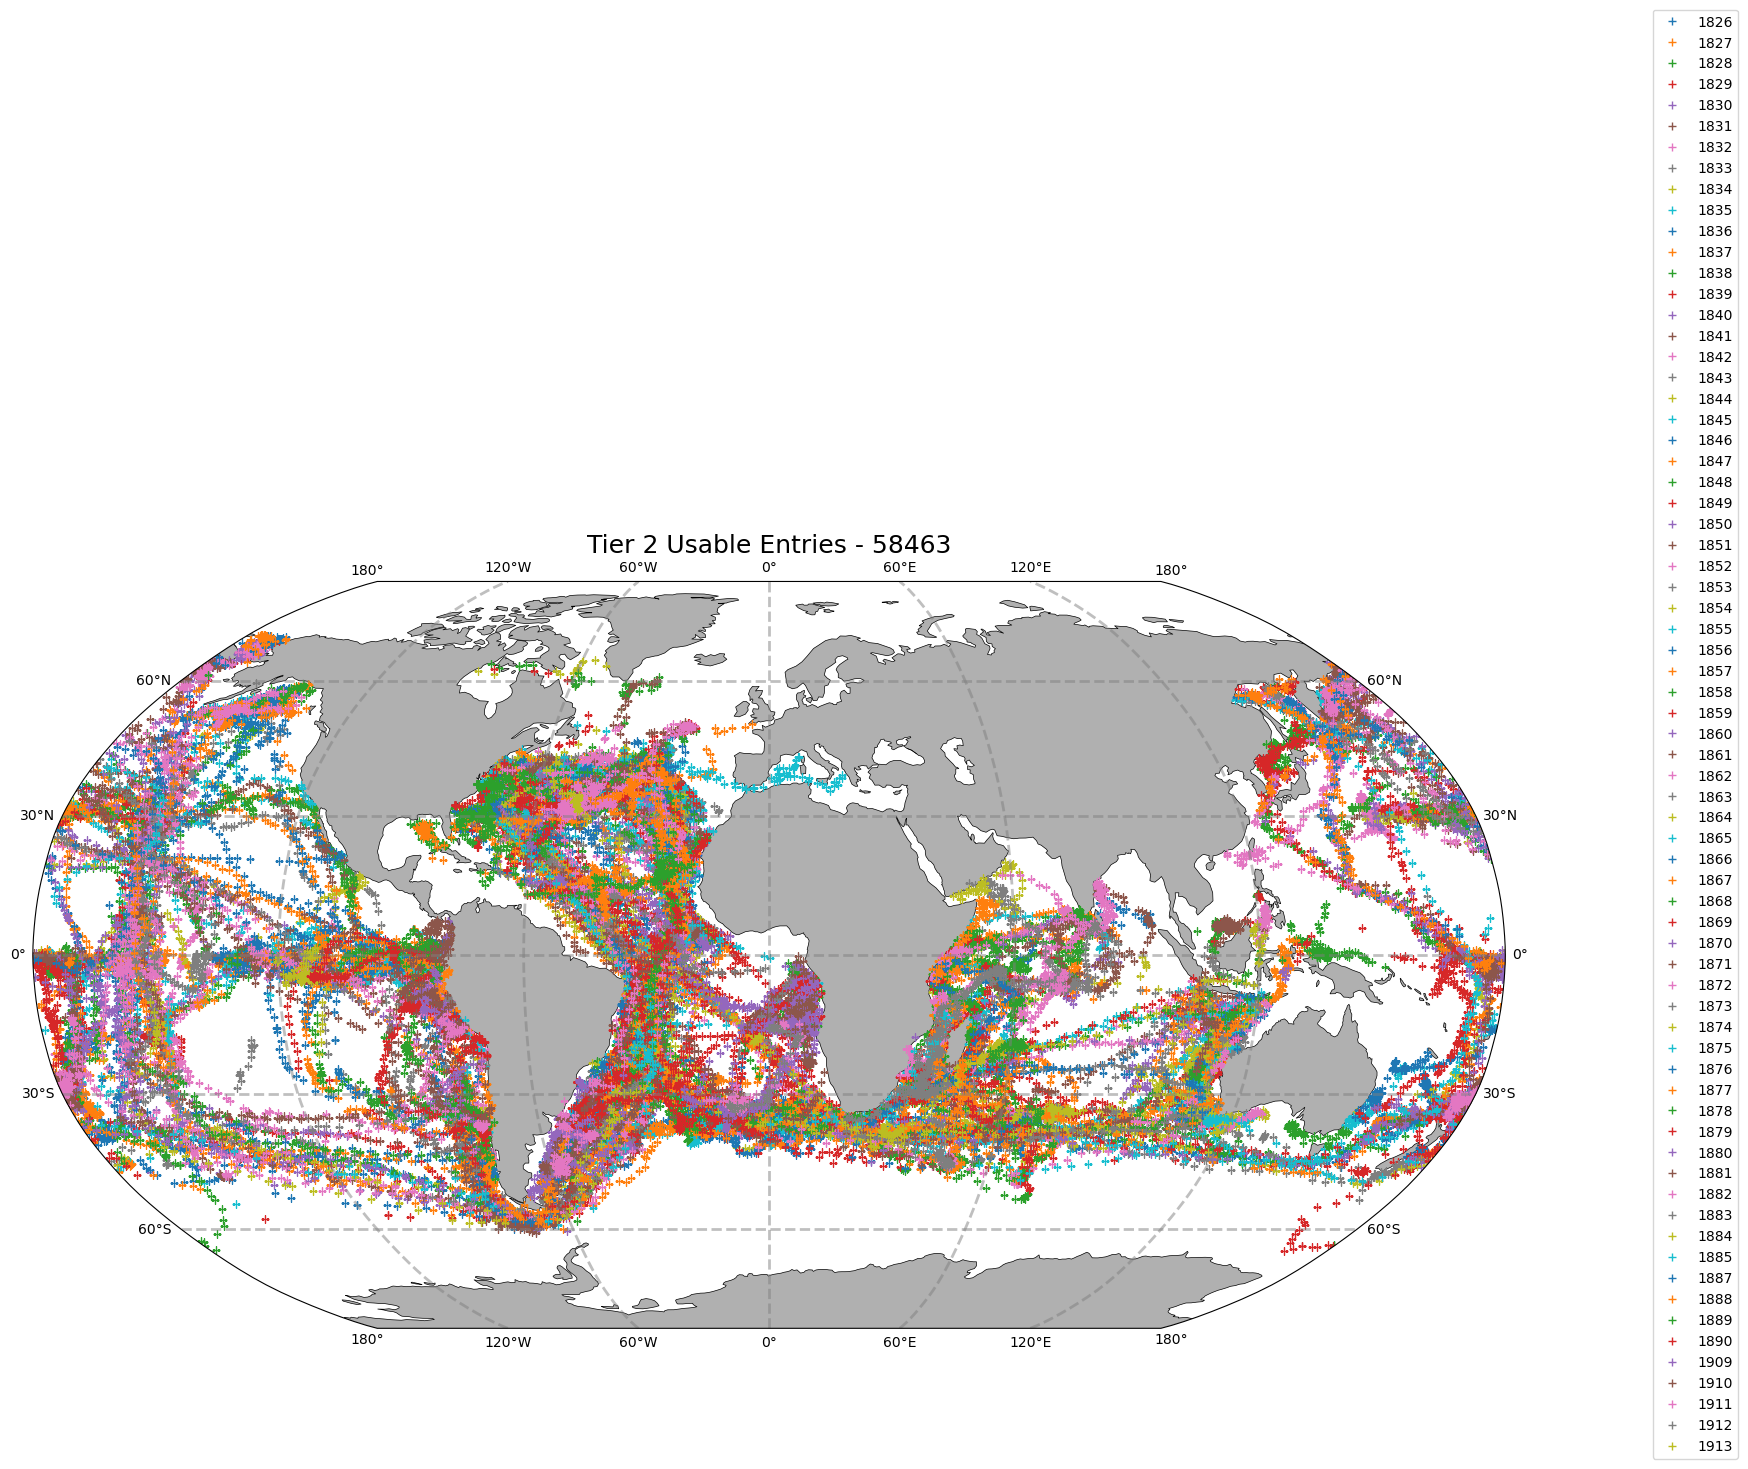

In [30]:
# Figure to plot new infilled coordinates with all usable data on a global map

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global() # adds global map
_ = ax.coastlines(linewidth=0.5) # adds coastlines to map 
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0') # infills land as grey 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') # adds lat/lon lines

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting the Tier 2 (one day infilled) data color coded by year
for yr in sorted(df.loc[(df['Tier2_usable'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier2_usable'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    print(yr, ': ', np.shape(work))

_ = ax.legend(loc=(1.1, -0.175)) # adds a legend
plt.title(f'Tier 2 Usable Entries - {num_plotted_values}', fontsize=18) # adds a title with number of entries

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier2_Clean_up_plot_usable_Jun10.svg'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Tier2_Clean_up_plot_usable_Jun10.jpg'), dpi=300, bbox_inches='tight')


Total number of plotted values: 58463


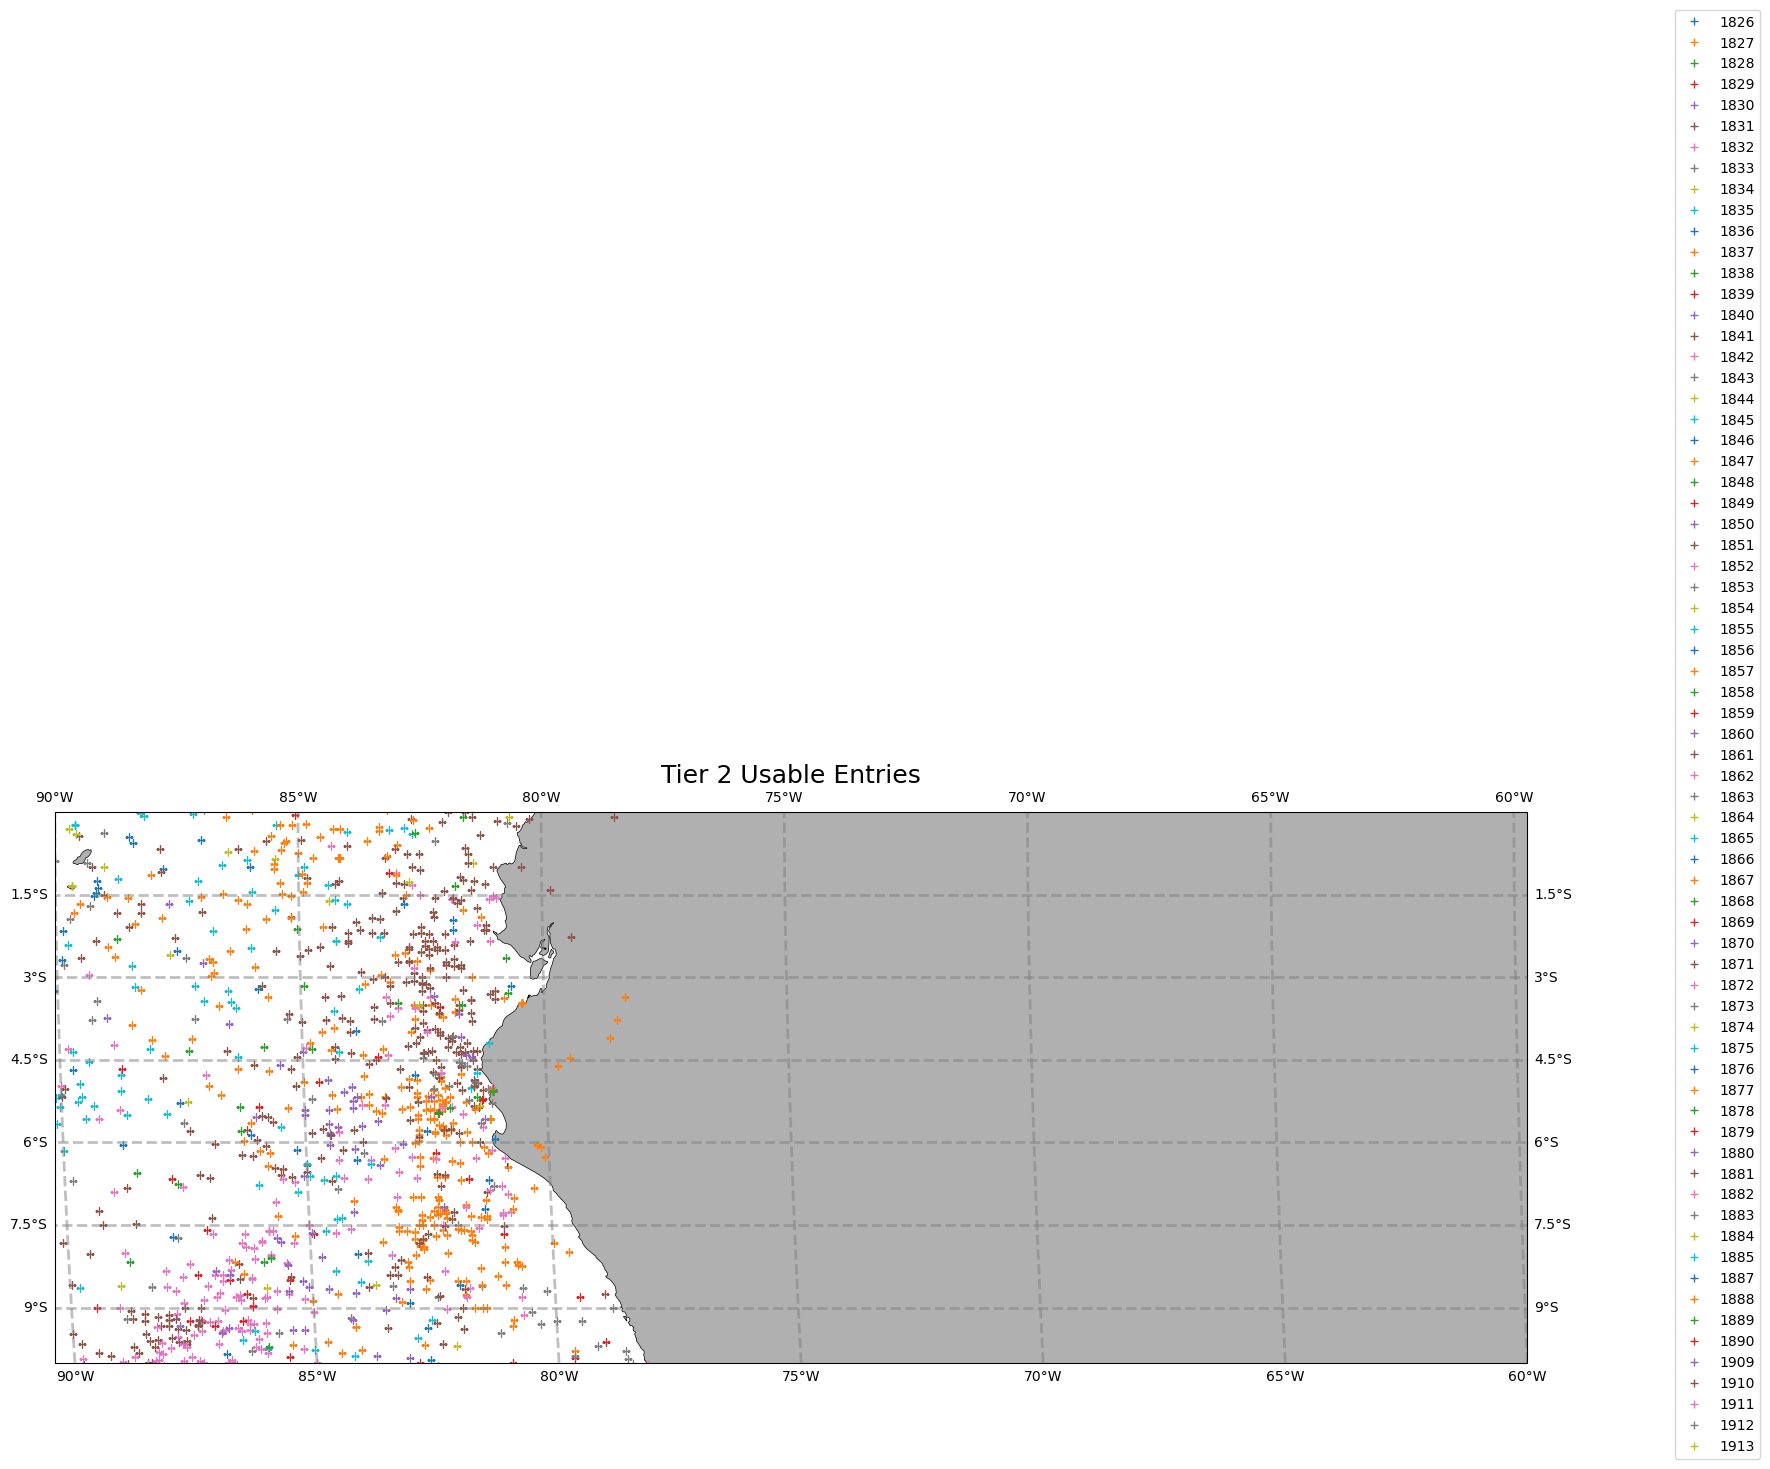

In [33]:
# Plotting all data with extents set to find points over land 
# Or points that look wrong, stand by themself in the global ocean

# Set Extent
extent = [-90, -60, -10, 0]
# extent = [minimum longitude, maximum longitude, minimum latitude, maximum latitude]

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
#_ = ax.set_global()
_ = ax.set_extent(extent, crs=ccrs.PlateCarree()) # Plot only the given extent to check data
_ = ax.coastlines(linewidth=0.5) # adds coastlines
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0') # adds land in grey
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') # adds lat/lon lines

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting the tier 2 data
for yr in sorted(df.loc[(df['Tier2_usable'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier2_usable'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    #print(yr, ': ', np.shape(work))

_ = ax.legend(loc=(1.1, -0.175)) # adds a legend
plt.title('Tier 2 Usable Entries', fontsize=18) # adds a title 

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

In [22]:
# Finding the logbook ID, ID, and coordinates of flagged data

# Filter the DataFrame based on latitude and longitude ranges
filtered_df = df[
    (df['Latitude'] >= -30) & (df['Latitude'] <= -22) & 
    (df['Longitude'] >= 130) & (df['Longitude'] <= 140)
]

# Display the filtered DataFrame
print(filtered_df[['LogBook ID', 'ID', 'Latitude', 'Longitude']])

Empty DataFrame
Columns: [LogBook ID, ID, Latitude, Longitude]
Index: []


In [23]:
# Creating a dataframe of the new infilled points for this tier
df['Tier2_new'] = ((df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna()) & 
                     (df["Infilled"] == True))
df_new2 = df[df['Tier2_new']==True]
df_new2

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,usable,usable_latlon,usable_lat,One Day Dist,Day 1 Infilled,One Day Lat,One Day Lon,Tier2_usable,Tier2_new
96387,1853-07-17 12:00:00,2455.0,A. Houghton (bark) 1853-1857,NaN,32.600000,-54.216667,True,NaN,NaN,NaN,NaN,NaN,135.0,moderate breezes,4.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-17 12:00:00,nan,SSE,False,False,False,True,NaN,True,NaN,-0.133333,True,True
96344,1853-08-21 12:00:00,2498.0,A. Houghton (bark) 1853-1857,NaN,39.183333,-30.908333,True,NaN,NaN,NaN,Flores Island,NaN,326.25,moderate winds,4.0,NaN,NaN,NaN,NaN,Cruising off the coast of Flores Lat and long ...,False,1853-08-21 12:00:00,nan,N to WNW,False,False,False,False,63.212291,True,0.500000,-0.350000,True,True
96324,1853-09-05 12:00:00,2518.0,A. Houghton (bark) 1853-1857,NaN,38.816667,-28.450000,True,NaN,NaN,NaN,"""Working to the Eastward down through the pasa...",NaN,NaN,light winds,2.0,calms,NaN,NaN,NaN,NaN,False,1853-09-05 12:00:00,nan,NaN,False,False,False,False,4.698285,True,0.033333,0.033333,True,True
96321,1853-09-07 12:00:00,2521.0,A. Houghton (bark) 1853-1857,NaN,38.900000,-27.783333,True,NaN,NaN,NaN,NaN,E,202.5,moderate breezes,4.0,NaN,NaN,NaN,NaN,Under reef sails,False,1853-09-07 12:00:00,nan,S to SSW,False,False,False,True,NaN,True,NaN,-1.366667,True,True
96309,1853-09-19 12:00:00,2533.0,A. Houghton (bark) 1853-1857,NaN,34.566667,-30.458333,True,NaN,NaN,NaN,NaN,SW,157.5,fresh and light winds,2.0,NaN,NaN,NaN,NaN,NaN,False,1853-09-19 12:00:00,nan,S to SSE,False,False,False,True,NaN,True,NaN,0.316667,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36157,1846-06-20 12:00:00,64230.0,Yeoman (Bark) 1843-1848,NaN,5.700000,-30.083333,True,NaN,NaN,NaN,NaN,NNE,135.0,moderate breezes,4.0,NaN,NaN,NaN,NaN,NaN,False,1846-06-20 12:00:00,nan,SE,False,False,False,True,NaN,True,NaN,-0.166667,True,True
36152,1846-06-23 12:00:00,64235.0,Yeoman (Bark) 1843-1848,NaN,8.000000,-30.708333,True,NaN,NaN,NaN,NaN,N,90.0,moderate breezes,4.0,NaN,NaN,several rain showers,NaN,NaN,False,1846-06-23 12:00:00,nan,E,False,False,False,True,NaN,True,NaN,1.250000,True,True
35826,1846-07-17 12:00:00,64568.0,Yeoman (Bark) 1843-1848,NaN,33.750000,-48.041667,True,NaN,NaN,NaN,NaN,NNE,90.0,strong breezes,6.0,NaN,NaN,fine weather,NaN,NaN,False,1846-07-17 12:00:00,nan,E,False,False,False,True,NaN,True,NaN,-0.583333,True,True
34813,1846-08-06 12:00:00,65597.0,Yeoman (Bark) 1843-1848,NaN,37.866667,-39.058333,True,NaN,NaN,NaN,NaN,E by S,225.0,strong breezes,6.0,NaN,NaN,NaN,NaN,NaN,False,1846-08-06 12:00:00,nan,SW,False,False,False,True,NaN,True,NaN,-0.450000,True,True


1827 :  (15, 33)
1828 :  (22, 33)
1829 :  (4, 33)
1830 :  (23, 33)
1831 :  (11, 33)
1832 :  (13, 33)
1833 :  (32, 33)
1834 :  (59, 33)
1835 :  (126, 33)
1836 :  (105, 33)
1837 :  (127, 33)
1838 :  (117, 33)
1839 :  (56, 33)
1840 :  (10, 33)
1841 :  (19, 33)
1842 :  (46, 33)
1843 :  (124, 33)
1844 :  (155, 33)
1845 :  (134, 33)
1846 :  (192, 33)
1847 :  (158, 33)
1848 :  (112, 33)
1849 :  (75, 33)
1850 :  (85, 33)
1851 :  (122, 33)
1852 :  (110, 33)
1853 :  (53, 33)
1854 :  (50, 33)
1855 :  (31, 33)
1856 :  (5, 33)
1857 :  (38, 33)
1858 :  (15, 33)
1859 :  (17, 33)
1860 :  (3, 33)
1861 :  (15, 33)
1862 :  (7, 33)
1863 :  (7, 33)
1864 :  (30, 33)
1865 :  (51, 33)
1866 :  (53, 33)
1867 :  (29, 33)
1868 :  (25, 33)
1869 :  (14, 33)
1870 :  (2, 33)
1871 :  (7, 33)
1872 :  (4, 33)
1874 :  (10, 33)
1875 :  (15, 33)
1877 :  (30, 33)
1878 :  (99, 33)
1879 :  (150, 33)
1880 :  (84, 33)
1881 :  (52, 33)
1882 :  (53, 33)
1883 :  (14, 33)
1884 :  (14, 33)
1885 :  (7, 33)
1887 :  (3, 33)
1888 :  (8,

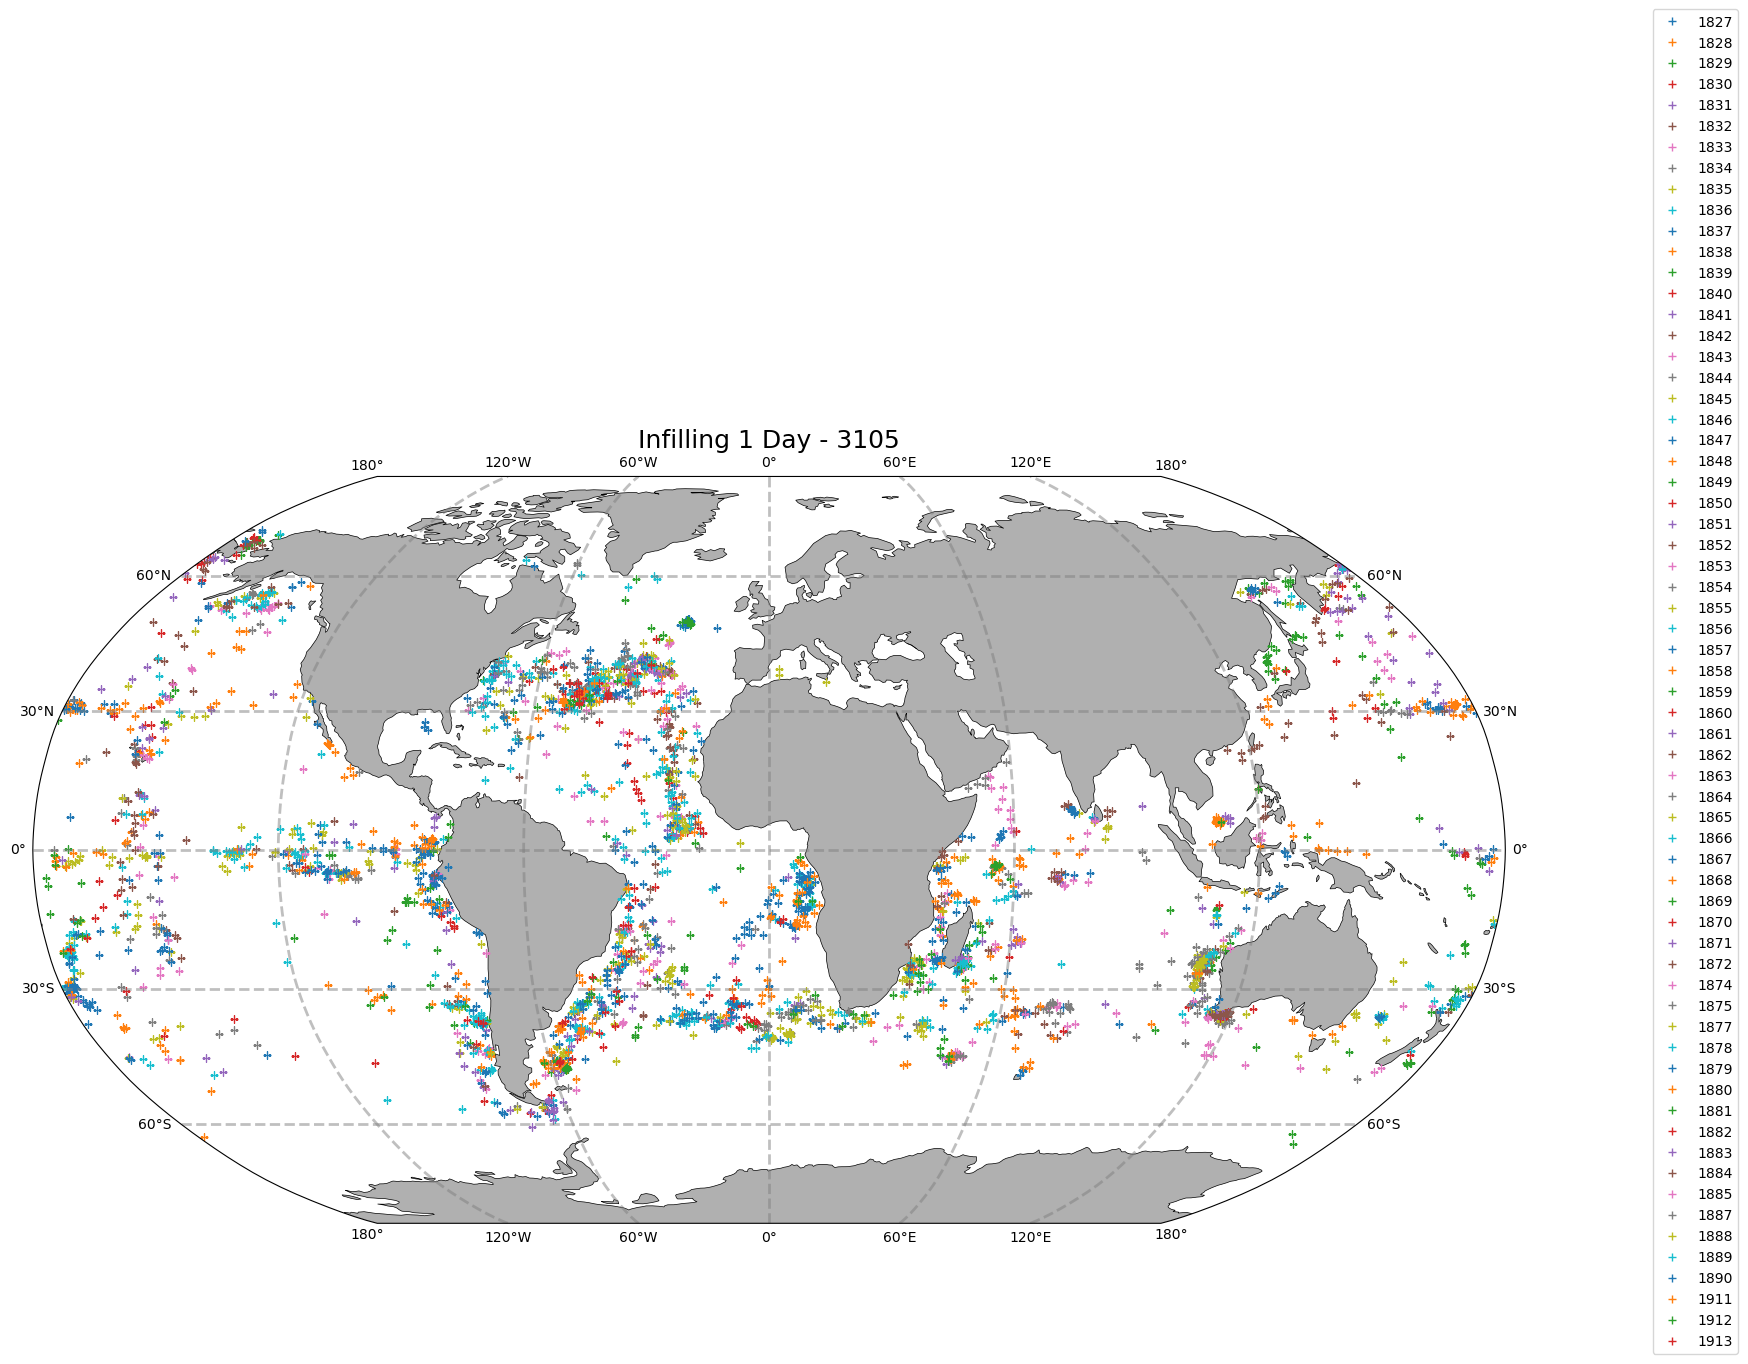

In [32]:
# Figure to plot new tier 2 infilled coordinates on a global map

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting only the new one day infilled values color coded by year 
for yr in sorted(df.loc[(df['Tier2_new'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier2_new'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    print(yr, ': ', np.shape(work))

_ = ax.legend(loc=(1.1, -0.175))
plt.title(f'Infilling 1 Day - {num_plotted_values}', fontsize=18)

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier2_Infilled_Jun10.svg'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Tier2_Infilled_Jun10.jpg'), dpi=300, bbox_inches='tight')


Total number of plotted values: 3105


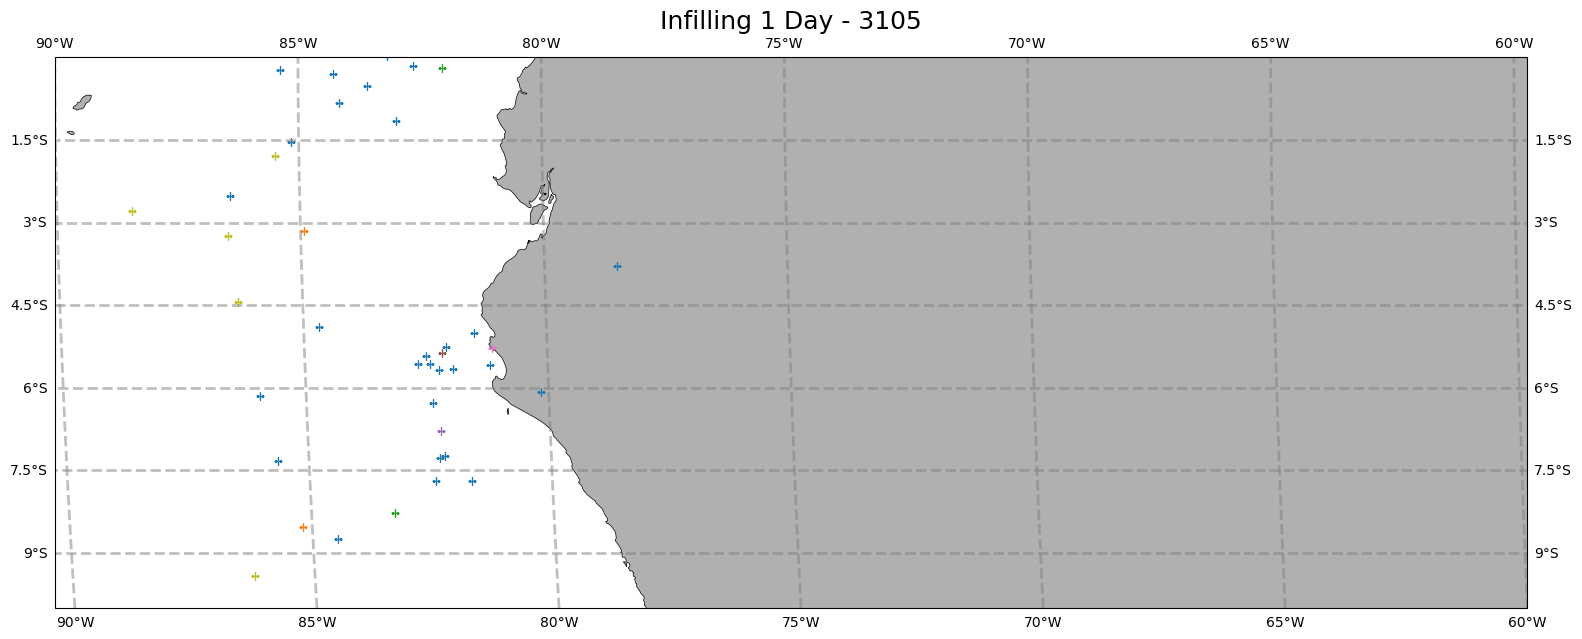

In [35]:
# Figure to plot new infilled coordinates with all data on a global map
# Same figure as above but setting an extent to make sure the values are being infilled correctly

# Set extent
extent = [-90, -60, -10, 0]

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
#_ = ax.set_global()
_ = ax.set_extent(extent, crs=ccrs.PlateCarree())
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting only the new one day infilled values color coded by year 
for yr in sorted(df.loc[(df['Tier2_new'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier2_new'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    #print(yr, ': ', np.shape(work))

#_ = ax.legend(loc=(1.1, -0.175))
plt.title(f'Infilling 1 Day - {num_plotted_values}', fontsize=18)

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

In [36]:
#Finding the logbook ID, ID, and coordinates of flagged data

# Filter the DataFrame based on latitude and longitude ranges
filtered_df = df[
    (df['Latitude'] >= -5) & (df['Latitude'] <= -3) & 
    (df['Longitude'] >= -80) & (df['Longitude'] <= -75)
]

# Display the filtered DataFrame
print(filtered_df[['LogBook ID', 'ID', 'Latitude', 'Longitude']])

                        LogBook ID       ID  Latitude  Longitude
75358  Phoebe Ann (Ship) 1826-1829  24477.0 -3.366667 -78.333333
75357  Phoebe Ann (Ship) 1826-1829  24478.0 -3.783333 -78.500000
75356  Phoebe Ann (Ship) 1826-1829  24479.0 -4.100000 -78.666667
75355  Phoebe Ann (Ship) 1826-1829  24480.0 -4.466667 -79.500000
75354  Phoebe Ann (Ship) 1826-1829  24481.0 -4.616667 -79.750000


In [25]:
# Creating a dataframe of the new infilled points for this tier

# Infilling one day df
df['Day 1'] = ((df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna()) & 
                     (df["Day 1 Infilled"] == True))
df_day1 = df[df['Day 1']==True]
print('1 Day:', len(df_day1))

1 Day: 3105


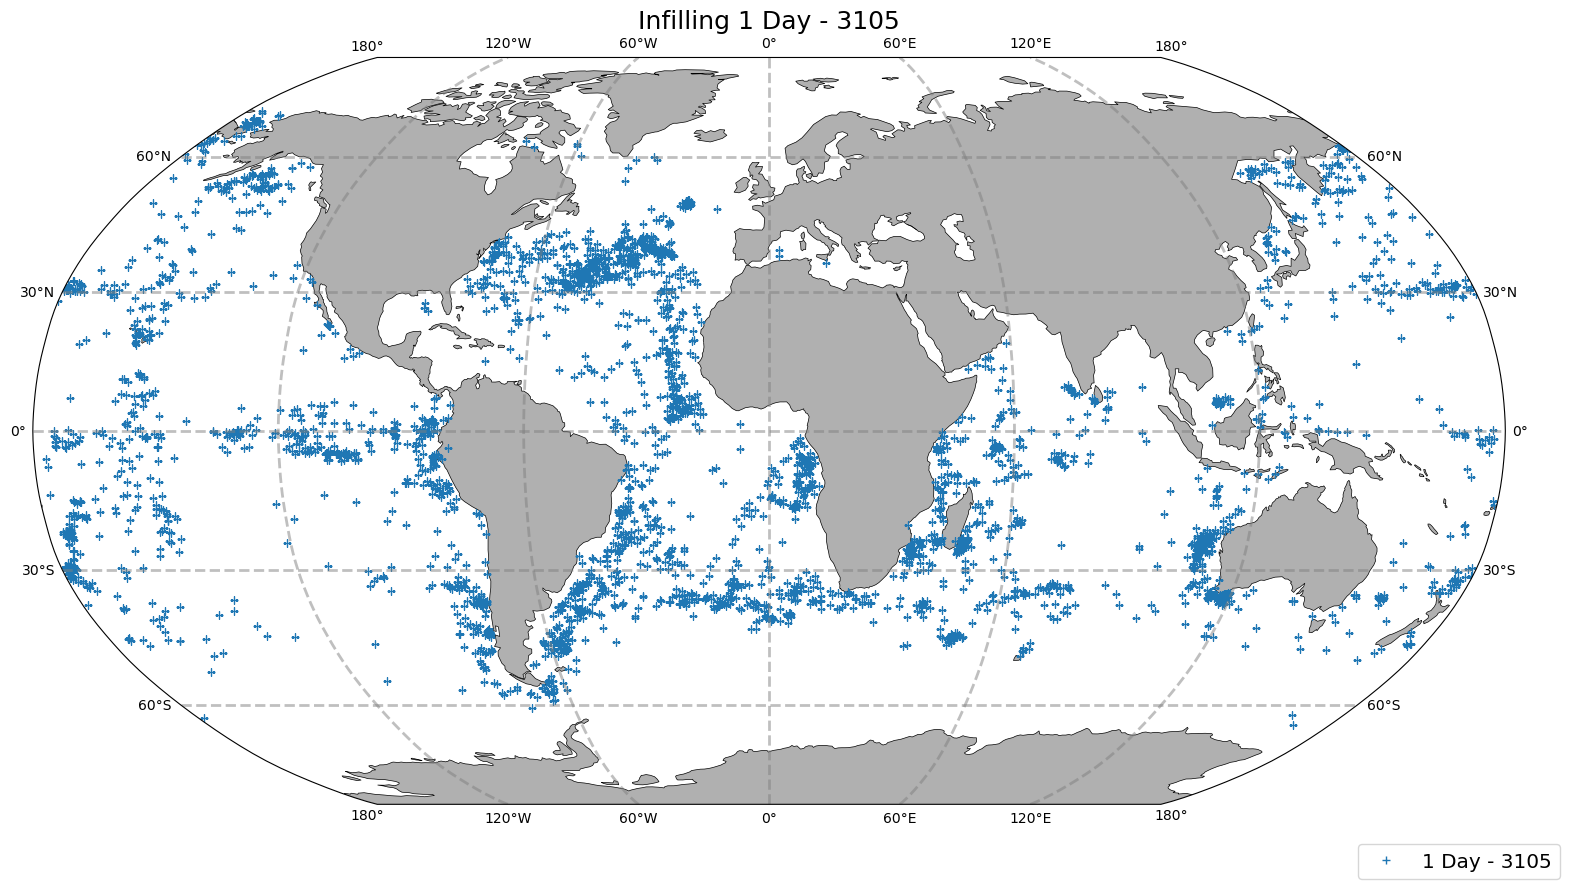

In [26]:
# Figure to plot new one day infilled coordinates on a global map

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plotting the data - infilling one day
_ = ax.plot(df_day1['Longitude'], df_day1['Latitude'], '+', \
        	transform=ccrs.PlateCarree(), label=f'1 Day - {len(df_day1)}')

_ = ax.legend(loc=(0.90, -0.10), fontsize = 'x-large')
plt.title(f'Infilling 1 Day - {num_plotted_values}', fontsize=18)

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier2_Infilled_by_day_Jun10.jpg'), dpi=300, bbox_inches='tight')


In [27]:
# Dropping the extra infilling columns
columns_to_drop = ['Day 1 Infilled', 'Day 1']
df.drop(columns = columns_to_drop, inplace = True)

### Save data to CSV

In [28]:
df.to_csv(os.path.join(CSV, 'Tier2_logentries-export-2024-06-10.csv'), index = False) #.csv file seems unreadable, don't know what the issue is: using pickle instead
df.to_pickle("Tier2_logentries-export-2024-06-10.pkl")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96383 entries, 12264 to 21835
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DateTime                    96378 non-null  object        
 1   ID                          96380 non-null  float64       
 2   LogBook ID                  96379 non-null  object        
 3   Page                        59413 non-null  float64       
 4   Latitude                    75798 non-null  float64       
 5   Longitude                   65974 non-null  float64       
 6   Infilled                    96383 non-null  bool          
 7   Depth                       2134 non-null   float64       
 8   Depth Unit                  22937 non-null  object        
 9   Bottom                      63 non-null     object        
 10  Landmark                    15197 non-null  object        
 11  Ship Heading/Course         53219 non-null  object     

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,usable,usable_latlon,usable_lat,One Day Dist,One Day Lat,One Day Lon,Tier2_usable,Tier2_new
12264,4.5,4.5,4.5,4.5,NaN,NaN,False,4.5,4.5,4.5,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaT,nan,NaN,False,False,False,False,NaN,NaN,NaN,False,False
12266,10,10.0,10,10.0,NaN,NaN,False,10.0,10,10,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaT,nan,NaN,False,False,False,False,NaN,NaN,NaN,False,False
96400,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.85,-58.466667,False,NaN,NaN,NaN,NaN,SE,225.0,moderate gales,7.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-06 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,True,False
96398,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.25,-55.066667,False,NaN,NaN,NaN,NaN,NaN,225.0,fresh breezes,5.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-07 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,True,False
96397,1853-07-08 12:00:00,2445.0,A. Houghton (bark) 1853-1857,NaN,35.00,-53.400000,False,NaN,NaN,NaN,NaN,SE,NaN,NaN,NaN,NaN,NaN,fine,NaN,NaN,False,1853-07-08 12:00:00,nan,NaN,False,False,True,True,NaN,NaN,NaN,False,False
